# rsHRF explore


**retrieves the onsets of pseudo-events triggering a haemodynamic response from resting state fMRI BOLD voxel-wise signal**

A.L. 2022-03-03

See the README.md file how to set up:

```
conda deactivate                                             # no conda environments (even not "base")
sage --pip install rsHRF                                     # install the rsHRF toolbox in sage
sage --pip install nilearn                                   # install the Nilearn package in sage
sage --pip install mat4py                                    # load & save data in Matlab format in sage
sage --pip install git+https://github.com/ANTsX/ANTsPy.git   # install ANTsPy package in sage (long time)

sage -n                                          # start a Jupyter Notebook (with the SageMath 9.5 kernel)
```


SIDE NOTE: For some nice **visualization tools**, check:

- https://nanslice.readthedocs.io/en/latest (`pip install nanslice`)  and https://hub.gke2.mybinder.org/user/spinicist-nanslice-rnukq9z8/notebooks/doc/example.ipynb 
- https://github.com/rordenlab/MRIcroGL from Chris Rorden lab: v1.2 GLSL volume rendering. Able to view NIfTI, DICOM, MGH, MHD, NRRD, AFNI format imag

In [1]:
!rsHRF --help

usage: rsHRF [-h]
             (--ts TS | --input_file INPUT_FILE | --bids_dir [BIDS_DIR] | --GUI)
             [--output_dir OUTPUT_DIR] [--n_jobs N_JOBS] [-V]
             [--analysis_level [{participant}]]
             [--participant_label PARTICIPANT_LABEL [PARTICIPANT_LABEL ...]]
             [--bids_filter_file BIDS_FILTER_FILE]
             [--atlas ATLAS | --brainmask]
             [--estimation {canon2dd,sFIR,FIR,fourier,hanning,gamma}]
             [--passband LOW_FREQ HIGH_FREQ]
             [--passband_deconvolve LOW_FREQ HIGH_FREQ] [-TR TR] [-T T]
             [-T0 T0] [-TD_DD TD_DD] [-AR_lag AR_LAG] [--thr THR]
             [--temporal_mask TEMPORAL_MASK] [--order ORDER] [--len LEN]
             [--min_onset_search MIN_ONSET_SEARCH]
             [--max_onset_search MAX_ONSET_SEARCH] [--localK LOCALK]
             [--wiener]

retrieves the onsets of pseudo-events triggering a haemodynamic response from
resting state fMRI BOLD voxel-wise signal

optional arguments:
  -h, --

## BIDS validation

Go to http://bids-standard.github.io/bids-validator/ and select a folder with your BIDS dataset (e.g. `./data/mybids`)

### Extract a single voxel timecourse from the rs-fMRI recording in sub-01

Template: `rsHRF --ts input_file.txt --estimation hanning --output_dir results -TR 2.0`

In [3]:
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import nibabel as nib
import nilearn
import ants
import matplotlib.pyplot as plt


mydir= './data/mybids'
mysubj = '01'

rest_name = f'{mydir}/sub-{mysubj}/func/sub-{mysubj}_task-rest_bold'
anat_name = f'{mydir}/sub-{mysubj}/anat/sub-{mysubj}_T1w'

rest_img_fn = f'{rest_name}.nii.gz'
rest_json_fn = f'{rest_name}.json'

anat_img_fn = f'{anat_name}.nii.gz'
anat_json_fn = f'{anat_name}.json'

rest_img = nib.load(rest_img_fn)
anat_img = nib.load(anat_img_fn)
 

with open(rest_json_fn) as json_data:
    jdata = json.load(json_data)

In [4]:
jdata.items()

dict_items([('AcquisitionMatrixPE', 64), ('AcquisitionNumber', 1), ('AcquisitionTime', '14:37:26.780000'), ('BandwidthPerPixelPhaseEncode', 48.077), ('BaseResolution', 64), ('BodyPartExamined', 'BRAIN'), ('ConsistencyInfo', 'N4_VD13D_LATEST_20130810'), ('ConversionSoftware', 'dcm2niix'), ('ConversionSoftwareVersion', 'v1.0.20190410  (JP2:OpenJPEG) (JP-LS:CharLS) MSC1900'), ('DerivedVendorReportedEchoSpacing', 0.000649999), ('DeviceSerialNumber', '66035'), ('DwellTime', 4.4e-06), ('EchoTime', 0.03), ('EchoTrainLength', 31), ('EffectiveEchoSpacing', 0.000324999), ('FlipAngle', 90), ('ImageComments', 'Reference_volume_for_motion_correction.'), ('ImageOrientationPatientDICOM', [0.996788, 0.00126201, 0.0800744, 3.94129e-09, 0.999876, -0.0157585]), ('ImageType', ['ORIGINAL', 'PRIMARY', 'M', 'ND', 'MOCO', 'MOSAIC']), ('ImagingFrequency', 123.256), ('InPlanePhaseEncodingDirectionDICOM', 'COL'), ('InstitutionAddress', 'NA'), ('InstitutionName', 'NA'), ('InstitutionalDepartmentName', 'NA'), ('MR

**Find TR time**

In [5]:
for key, value in jdata.items(): 
    if key == 'RepetitionTime':
        TR = value
        print(f"TR in  subj-{mysubj}'s rs-fMRI recording is {value} sec")

TR in  subj-01's rs-fMRI recording is 2.24 sec


**Find other information about the rs-fMRI recording**

In [6]:
print('functional file name', rest_img.get_filename())
print('shape of image = ', rest_img.header.get_data_shape())
print('units = ', rest_img.header.get_xyzt_units())
print('voxel size = ', rest_img.header.get_zooms())
print('dtype = %s' % rest_img.header.get_data_dtype())
data = rest_img.get_fdata()
print('data shape', data.shape)
print('min = %d' % data.min())
print('max = %d' % data.max())
print('number of timepoints =', rest_img.shape[-1])

functional file name ./data/mybids/sub-01/func/sub-01_task-rest_bold.nii.gz
shape of image =  (64, 64, 40, 200)
units =  ('mm', 'sec')
voxel size =  (3.0, 3.0, 3.3, 2.24)
dtype = int16
data shape (64, 64, 40, 200)
min = 0
max = 1882
number of timepoints = 200


**Find information about the 3D T1w MRI recording**

In [7]:
print('structural file name', anat_img.get_filename())
print('shape of image = ', anat_img.header.get_data_shape())
print('units = ', anat_img.header.get_xyzt_units())
print('voxel size = ', anat_img.header.get_zooms())
print('dtype = %s' % anat_img.header.get_data_dtype())
sdata = anat_img.get_fdata()
print('data shape', sdata.shape)
print('min = %d' % sdata.min())
print('max = %d' % sdata.max())

structural file name ./data/mybids/sub-01/anat/sub-01_T1w.nii.gz
shape of image =  (192, 256, 256)
units =  ('mm', 'sec')
voxel size =  (1.0, 1.0, 1.0)
dtype = int16
data shape (192, 256, 256)
min = 0
max = 2718


## Using ANTsPy functions

See: https://antspy.readthedocs.io/en/latest

In [8]:
aimg = ants.image_read(anat_img_fn)   # 3D T1w MRI
fimg = ants.image_read(rest_img_fn)   # 4D rs-fMRI BOLD

In [9]:
aimg

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (192, 256, 256)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (105.4421, 86.7565, -120.4132)
	 Direction  : [-9.963e-01  3.900e-03 -8.530e-02 -3.900e-03 -1.000e+00 -3.000e-04
 -8.530e-02 -0.000e+00  9.964e-01]


In [10]:
fimg

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (64, 64, 40, 200)
	 Spacing    : (3.0, 3.0, 3.3, 2.24)
	 Origin     : (-92.1086, 55.6764, -45.2941, 0.0)
	 Direction  : [ 0.9968 -0.     -0.0801  0.      0.0013 -0.9999  0.0157  0.      0.0801
  0.0158  0.9967  0.      0.      0.      0.      1.    ]


### Masking the data: from 4D image to 2D array

While functional neuroimaging data consist in 4D images, positioned in a coordinate space (which we will call Niimgs). For use with the scikit-learn, they need to be converted into 2D arrays of samples and features.

![img](https://nilearn.github.io/_images/niimgs.jpg)

$$
\Bigg\downarrow
$$


![img](https://nilearn.github.io/_images/feature_array.jpg)

We use masking to convert 4D data (i.e. 3D volume over time) into 2D data (i.e. voxels over time). For this purpose, we use the NiftiMasker object, a very powerful data loading tool.

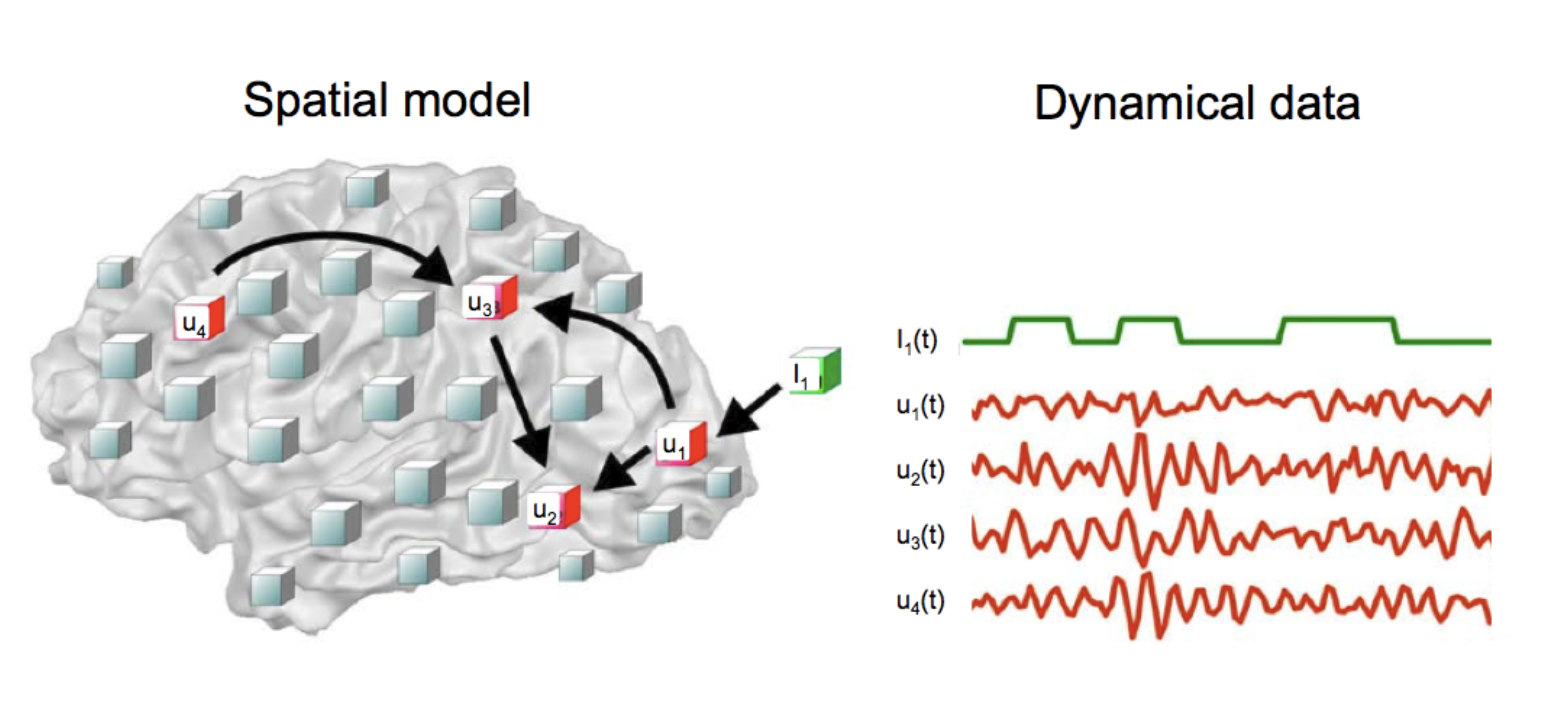

In [11]:
from IPython.display import Image
Image(filename='./assets/network_brain_spatial_dynamic.png', width=800)

#### Extracting brain mask from 4D rs-fMRI

In [12]:
from nilearn.masking import compute_epi_mask


rest_img = nib.load(rest_img_fn)
mask_img = compute_epi_mask(rest_img_fn)

In [13]:
# Get voxel dimensions
voxel_dims = (rest_img.header["pixdim"])[1:4]
print("Voxel dimensions:")
print("  x = {} mm".format(voxel_dims[0]))
print("  y = {} mm".format(voxel_dims[1]))
print("  z = {} mm".format(voxel_dims[2]))

# Compute volume
nonzero_voxel_count = np.count_nonzero(mask_img.get_fdata())
nonzero_voxel_count2 = np.sum(mask_img.get_fdata() != 0)

voxel_volume = np.prod(voxel_dims)
nonzero_voxel_volume = nonzero_voxel_count * voxel_volume

print("Number of non-zero voxels = {}".format(nonzero_voxel_count))
print("Volume of non-zero voxels = {} mm^3".format(nonzero_voxel_volume))
nonzero_voxel_count2

Voxel dimensions:
  x = 3.0 mm
  y = 3.0 mm
  z = 3.299999952316284 mm
Number of non-zero voxels = 46798
Volume of non-zero voxels = 1389900.5464439392 mm^3


46798

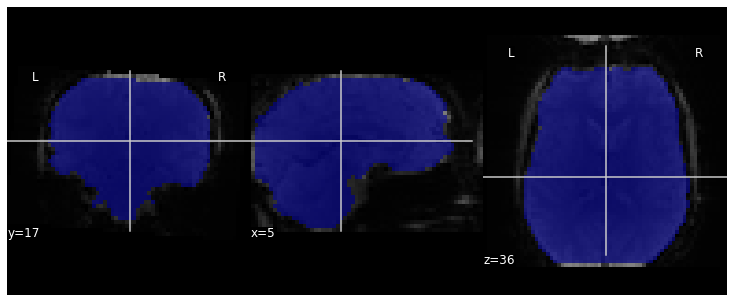

In [14]:
# Visualize it as an ROI
from nilearn.plotting import plot_roi
from nilearn.image.image import mean_img


mean_rest = mean_img(rest_img)

fig = plt.figure(figsize=(10, 4))

plot_roi(mask_img, mean_rest, figure=fig)
plt.show()

#### Applying the mask to extract the corresponding time series

In [15]:
from nilearn.masking import apply_mask

masked_data = apply_mask(rest_img_fn, mask_img)


# masked_data shape is (timepoints, voxels)
masked_data.shape

(200, 46798)

#### Plotting a couple of voxel time courses (without any preprocessing) withinin the brain mask

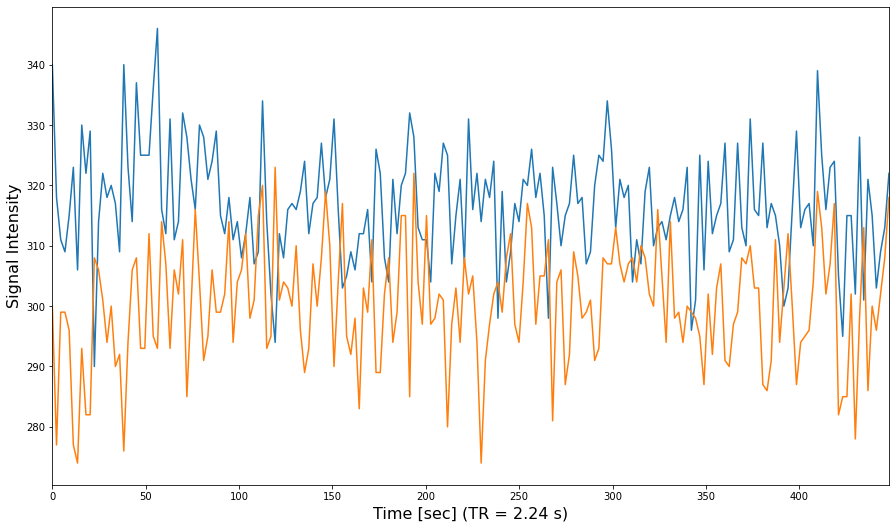

In [35]:
plt.figure(figsize=(14, 8))

ns = rest_img.shape[-1]
x = np.linspace(0.0, ns*TR, ns)

plt.plot(x, masked_data[:, :2])
plt.xlabel(f'Time [sec] (TR = {TR} s)', fontsize=16)
plt.ylabel('Signal Intensity', fontsize=16)
plt.xlim(0, ns*TR)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

### Visualizing global patterns (not preprocessed) over time

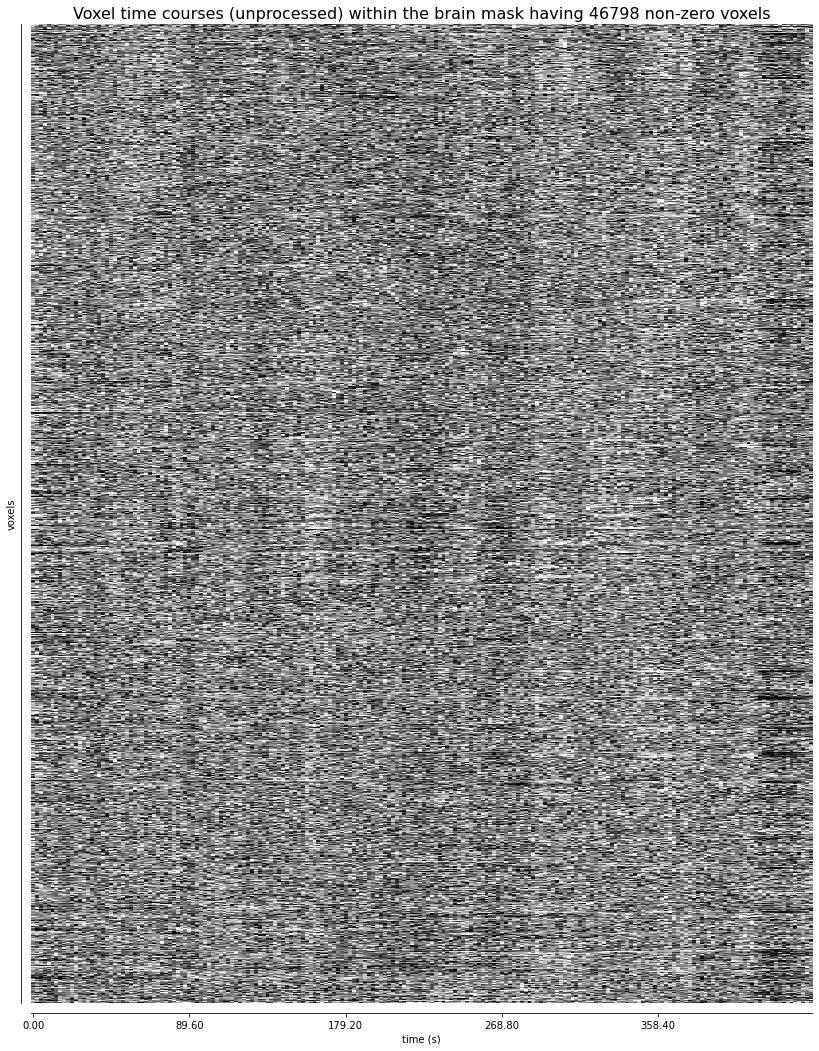

In [37]:
#import matplotlib
#matplotlib.use('TkAgg')

from nilearn.plotting import plot_carpet

fig = plt.figure(figsize=(14, 18))               
display = plot_carpet(rest_img, mask_img, figure=fig)
plt.title(f'Voxel time courses (unprocessed) within the brain mask having {nonzero_voxel_count} non-zero voxels', size=16)
plt.show()

#### Find (i,j,k) coordinates of brain mask using `np.where()`

In [18]:
rest_data = rest_img.get_fdata()
mask_data = mask_img.get_fdata()

ii, jj, kk = np.where(mask_data == 1)
print(len(ii), len(jj), len(kk))
print(ii[0], jj[0], kk[0])

46798 46798 46798
9 16 21


In [19]:
rest_data.shape

(64, 64, 40, 200)

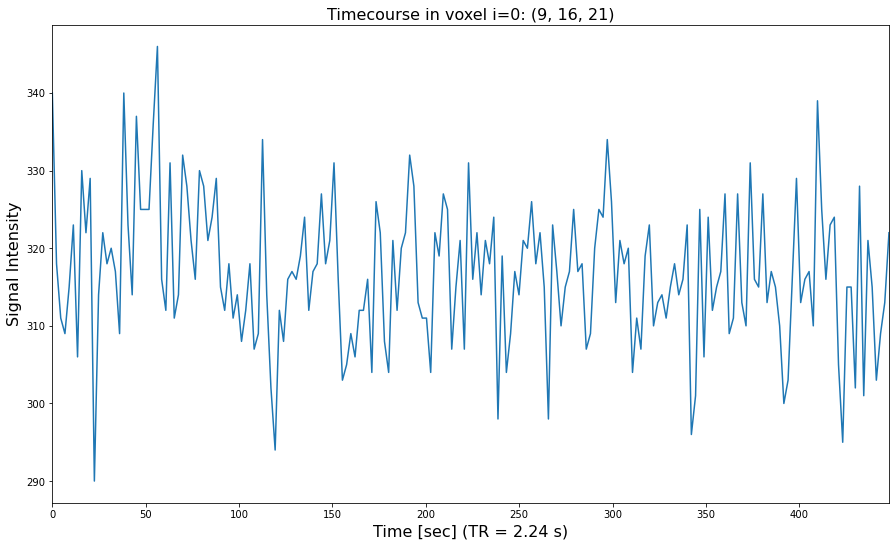

In [20]:
plt.figure(figsize=(14, 8))

ns = rest_img.shape[-1]
x = np.linspace(0.0, ns*TR, ns)

for i in [0]: # [0, 1, 2]:
    plt.plot(x, rest_data[ii[i], jj[i], kk[i], :])
plt.xlabel(f'Time [sec] (TR = {TR} s)', fontsize=16)
plt.ylabel('Signal Intensity', fontsize=16)
plt.xlim(0, ns*TR)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)
plt.title(f'Timecourse in voxel i={i}: ({ii[i]}, {jj[i]}, {kk[i]})', size=16)
plt.show()

**Select the i-th voxel timecourse in the brain mask and save its SI-values to text file**

In [21]:
i=0
time_course = rest_data[ii[i], jj[i], kk[i], :]

with open("./data/input_file.txt", "a") as f:
    for item in list(time_course):
        f.write(str(item) + "\n")

**Displaying the contents of the text file**

In [22]:
file = open("./data/input_file.txt", "r")
content = file.read()

print("Array contents of 50 first characters in input_file.txt:\n ", content[0:50])
file.close()

Array contents of 50 first characters in input_file.txt:
  340.0
318.0
311.0
309.0
315.0
323.0
306.0
330.0
32


## The rsHRF analysis of a single voxel timecourse

NOTE: The model is fitted to retrieve the shape of the estimated rsHRF which will depend on the by-the-toolbox predefined HRF basis functions (e.g.`hanning`)

In [23]:
%%time

!rsHRF --ts ./data/input_file.txt --estimation hanning --output_dir ./data/results -TR 2.24

Retrieving HRF ...
Assuming non interactive session since isatty found missing
Done
Deconvolving HRF ...
Done
Saving Output ...
Done
CPU times: user 26.9 ms, sys: 29.5 ms, total: 56.5 ms
Wall time: 1.73 s


**Check results**

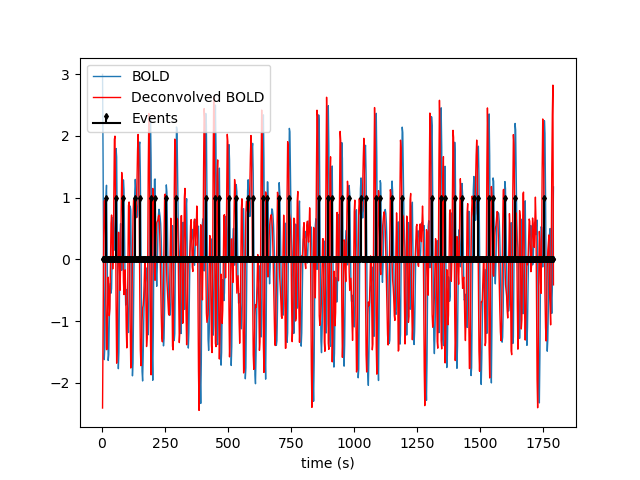

In [24]:
from IPython.display import Image
Image(filename='./assets/input_file_deconvolution_plot.png', width=900)

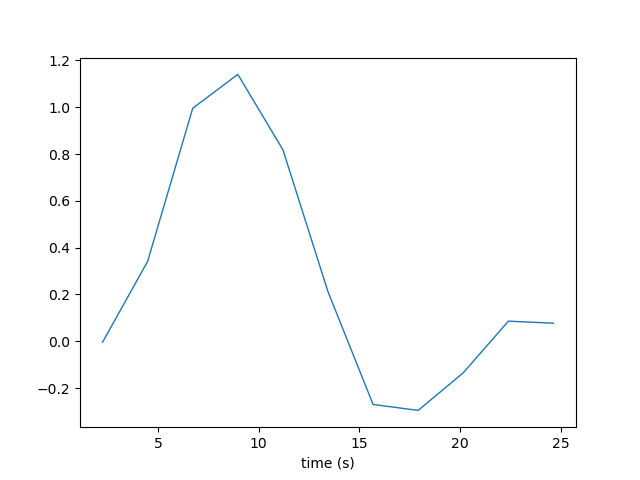

In [25]:
from IPython.display import Image
Image(filename='./assets/input_file_hrf_plot.png', width=900)

In [38]:
import scipy.io    # mat4py is better (see below)

mat = scipy.io.loadmat('./data/results/input_file_hrf_deconv.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Mar  3 22:51:15 2022',
 '__version__': '1.0',
 '__globals__': [],
 'para': array([[(array(['hanning'], dtype='<U7'), array([[0.01, 0.08]]), array([[0.00000000e+000, 1.79769313e+308]]), array([[2.24]]), array([[3]]), array([[1]]), array([[2]]), array([[1]]), array([[1]]), array([], shape=(0, 0), dtype=float64), array([[3]]), array([[24]]), array([[4]]), array([[8]]), array([[2]]), array([[0]], dtype=uint8), array([[0.74666667]]), array([[ 5,  6,  7,  8,  9, 10]]))]],
       dtype=[('estimation', 'O'), ('passband', 'O'), ('passband_deconvolve', 'O'), ('TR', 'O'), ('T', 'O'), ('T0', 'O'), ('TD_DD', 'O'), ('AR_lag', 'O'), ('thr', 'O'), ('temporal_mask', 'O'), ('order', 'O'), ('len', 'O'), ('min_onset_search', 'O'), ('max_onset_search', 'O'), ('localK', 'O'), ('wiener', 'O'), ('dt', 'O'), ('lag', 'O')]),
 'hrfa': array([[ 0.        ],
        [ 0.0352309 ],
        [ 0.15059576],
        [ 0.34015464],
        [ 0.5731979

### Load data from a MAT-file using `mat4py` and plot `'hrfa'`

https://pypi.org/project/mat4py

`pip install mat4py`

The function loadmat loads all variables stored in the MAT-file into a simple Python data structure, using only Python’s dict and list objects. Numeric and cell arrays are converted to row-ordered nested lists. Arrays are squeezed to eliminate arrays with only one element. The resulting data structure is composed of simple types that are compatible with the JSON format.

In [44]:
from mat4py import loadmat

mat = loadmat('./data/results/input_file_hrf_deconv.mat')
mat.keys()

dict_keys(['para', 'hrfa', 'event_bold', 'PARA', 'event_number', 'data_deconv'])

In [55]:
def get_my_hrfa(mat):
    for key, val in mat.items():
        if key == 'hrfa':
            return val
        
def flatten(t):
    return [item for sublist in t for item in sublist]

In [65]:
hrfa = flatten(get_my_hrfa(mat))

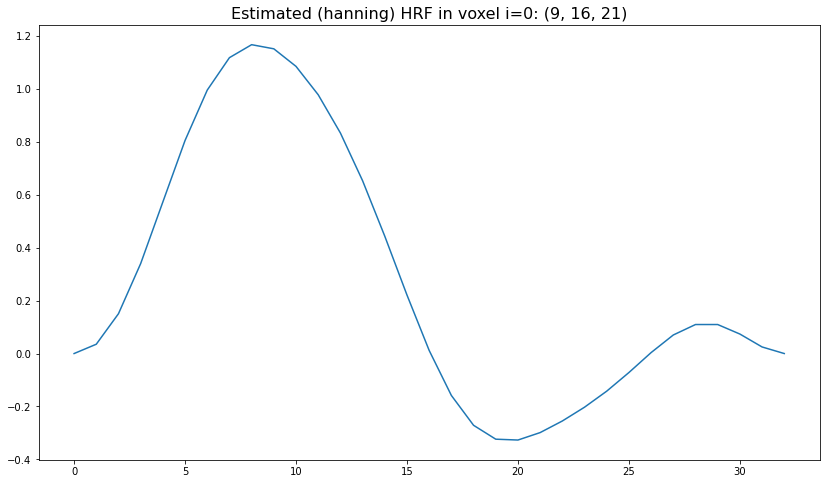

In [68]:
plt.figure(figsize=(14, 8))
plt.plot(hrfa)
plt.title(f'Estimated (hanning) HRF in voxel i={i}: ({ii[i]}, {jj[i]}, {kk[i]})', size=16)
plt.show()

## Running the rsHRF with a single input file

Template: `rsHRF --input_file input_file --estimation fourier --output_dir results`

In the above example,  the `input_file` can be a .nii/.nii.gz or .gii/ gii.gz image. The estimation method passed is fourier. The `-TR` argument (which represents the BOLD repetition time) needs to be supplied if a .gii/.gii.gz input file is used.

In [29]:
# In our case:
rest_img_fn

'./data/mybids/sub-01/func/sub-01_task-rest_bold.nii.gz'

In [30]:
%%time

!rsHRF --input_file './data/mybids/sub-01/func/sub-01_task-rest_bold.nii.gz' --estimation fourier --output_dir ./data/results -TR 2.24 --n_jobs 10 &>/dev/null


CPU times: user 2 s, sys: 375 ms, total: 2.38 s
Wall time: 3min 25s


DELL-Precision-7560 Ubuntu 20.04 (without `&>/dev/null`):
```
No atlas provided! Generating mask file...
Done
Retrieving HRF ...
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
Assuming non interactive session since isatty found missing
....
Done
Deconvolving HRF ...
Done
Saving Output ...
Done
CPU times: user 2.02 s, sys: 403 ms, total: 2.42 s
Wall time: 3min 24s
```

In [31]:
deconv_fn = f'./data/results/sub-{mysubj}_task-rest_deconv.nii.gz'
deconv_img = nib.load(deconv_fn)
deconv_data = deconv_img.get_fdata()
mn = deconv_data.min()
mx = deconv_data.max()

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# prepare data for standardization
# values = values.reshape((len(values), 1))

for i in [0]: # [0, 1, 2]:
    
    deconv_values = deconv_data[ii[i], jj[i], kk[i], :]
    mn = deconv_values.min()
    mx = deconv_values.max()
    
    values = rest_data[ii[i], jj[i], kk[i], :].reshape(-1, 1)
    
    # train the standardization/normalization
    # scaler = StandardScaler()
    scaler = MinMaxScaler(feature_range=(mn, mx))
    scaler = scaler.fit(values)
    
    normalized = scaler.transform(values)

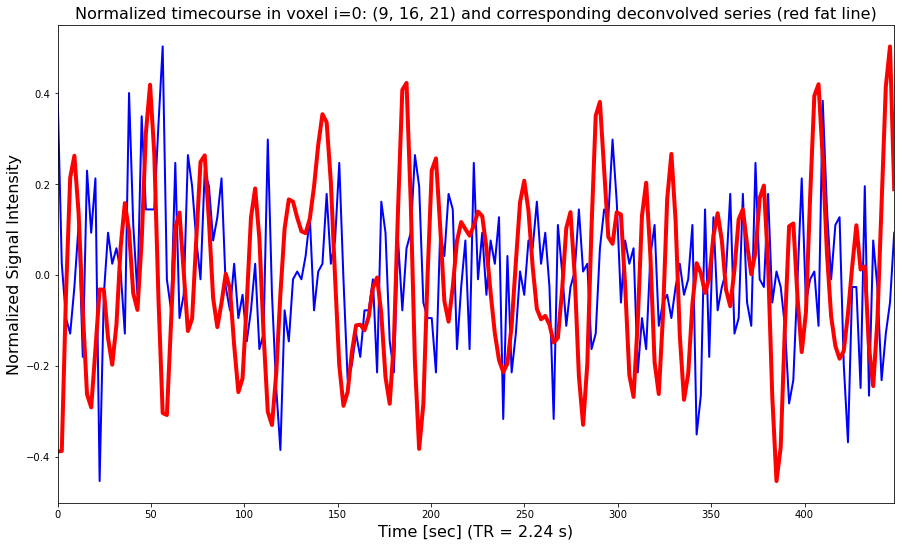

In [34]:
plt.figure(figsize=(14, 8))

ns = rest_img.shape[-1]
x = np.linspace(0.0, ns*TR, ns)


for i in [0]: # [0, 1, 2]:
    #plt.plot(x, rest_data[ii[i], jj[i], kk[i], :])
    plt.plot(x, normalized, 'b-', linewidth=2)
    plt.plot(x, deconv_data[ii[i], jj[i], kk[i], :], 'r-', linewidth=4)
    
plt.xlabel(f'Time [sec] (TR = {TR} s)', fontsize=16)
plt.ylabel('Normalized Signal Intensity', fontsize=16)
plt.xlim(0, ns*TR)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)
plt.title(f'Normalized timecourse in voxel i={i}: ({ii[i]}, {jj[i]}, {kk[i]}) and corresponding deconvolved series (red fat line)', size=16)
plt.show()

In [81]:
mat_hrf = loadmat('./data/results/sub-01_task-rest_hrf.mat')
#mat_hrf

In [82]:
mat_hrf.keys()

dict_keys(['para', 'hrfa', 'event_bold', 'PARA'])

In [93]:
a = get_my_hrfa(mat_hrf)
print(len(a))
a[0][0]

33


0.35774105513122756

In [87]:
# https://stackoverflow.com/questions/20151141/how-to-get-length-of-a-list-of-lists-in-python

print(reduce(lambda count, l: count + len(l), a, 0))

5382168


In [101]:
df = pd.DataFrame(a) 
df.shape

(33, 163096)

In [120]:
b = np.asarray(df).T
b.shape

(163096, 33)

In [121]:
b[0][:]

array([ 0.35774106,  0.47471728,  0.64188365,  0.84005229,  1.04121211,
        1.21489239,  1.33478573,  1.38387505,  1.35686119,  1.25956656,
        1.10590462,  0.9136592 ,  0.70051752,  0.48150638,  0.26832349,
        0.07028337, -0.10400953, -0.24537634, -0.34405843, -0.39129404,
       -0.38205027, -0.31788844, -0.20871045, -0.07237327,  0.06819279,
        0.18987799,  0.27505565,  0.31636805,  0.31910615,  0.30027517,
        0.28438674,  0.29700035,  0.35774106])

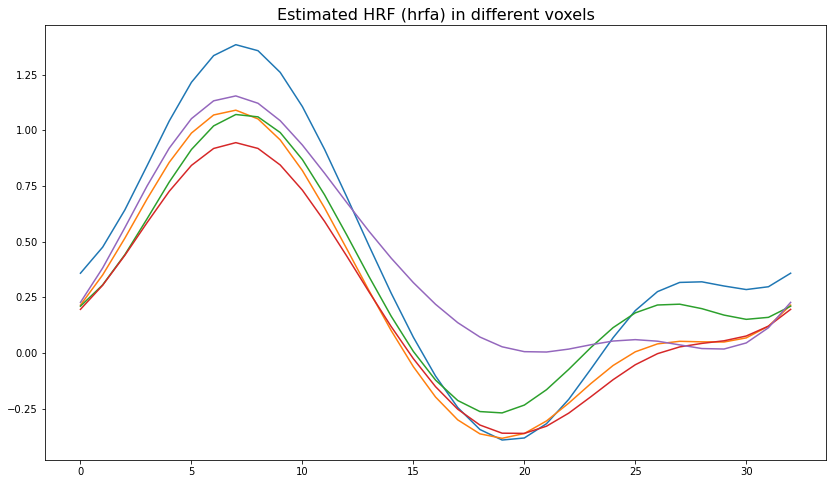

In [131]:
plt.figure(figsize=(14, 8))

for i in [0, 10, 100, 1000, 10000]:
    plt.plot(b[i][:])
plt.title(f'Estimated HRF (hrfa) in different voxels', size=16)
plt.show()
plt.show()

# NEXT steps:

- Spatial normalization (MIN space)
- Region-wise analysis (e.g. insula, basal ganglia)
- Group-wise analysis (e.g. IBS, PD, ...)

### Resample to MNI152 space obtaining `rimg` and `simg` using Nilearn

#### Registration (aka spatial normalization)

(From: http://jpeelle.net/mri/image_processing/registration.html)

A goal common to many neuroimaging studies is to learn something about how patterns of brain activity generalize from the volunteers tested to a broader population. In the case of MRI, this generally involves registering a group of participants’ brains into a common space. If the patterns of neural activation have a systematic relationship to macroanatomical structure (see below), then lining up these structures across volunteers allows us to make inferences about the level of group activity.


![img](http://jpeelle.net/mri/_images/registration.png)

In [39]:
### TO DO: Spatial normalization

```
from nilearn.image import resample_to_img
from nilearn.image.image import mean_img

rimg = rest_img
simg = anat_img

mean_rimg = mean_img(rimg)

resampled_simg = resample_to_img(simg, mean_rimg)

print('resampled_simg.shape\n', resampled_simg.shape)
print('rimg.shape\n', rimg.shape)
print('resampled_simg.affine\n', resampled_simg.affine)
print('rimg.affine\n', rimg.affine)
```

**Coordinates of Default Mode (MNI152 space)**

In [43]:
dmn_coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
labels = [
          'Posterior Cingulate Cortex',
          'Left Temporoparietal junction',
          'Right Temporoparietal junction',
          'Medial prefrontal cortex',
         ]
dmn_node_cols = ['r', 'g', 'b', 'k']

```
from nilearn import plotting
from nilearn.plotting import plot_epi, plot_anat, show

print('mean_rimg:')
plot_epi(mean_rimg, cut_coords=dmn_coords[0])
plotting.show()
```

```
print('resampled_simg:')
plot_epi(resampled_simg, cmap = 'gray', cut_coords=dmn_coords[0])
plotting.show()
```